# High-Frequency Grid Trading - Simplified from GLFT

One of the challenges in using the GLFT model is that it assumes a parametric form for order arrival intensity. However, in some cases, the data does not fit this function well. To address this, you can replace the parametric model with non-parametric approaches, such as using a simple mean, median, or a percentile estimate. A simpler solution is to remove the dynamic estimation of spread and skew based on order arrival intensity, relying only on volatility.

This issue is more common in pairs with a large tick size. As demonstrated in [the large tick size assets example](https://hftbacktest.readthedocs.io/en/latest/tutorials/Queue-Based%20Market%20Making%20in%20Large%20Tick%20Size%20Assets.html), the problem can be mitigated by incorporating the micro price. While the BBO-based micro price has little impact on pairs with small tick sizes, it can be highly effective for large tick size pairs.

In [1]:
import json
import datetime
import itertools

from multiprocessing import Pool

import polars as pl

import numpy as np

from numba import njit, uint64, float64
from numba.typed import Dict

from matplotlib import pyplot as plt

from hftbacktest import BUY, SELL, GTX, LIMIT, BUY_EVENT, SELL_EVENT
from hftbacktest import BacktestAsset, ROIVectorMarketDepthBacktest, Recorder
from hftbacktest.stats import LinearAssetRecord

@njit
def gridtrading(hbt, recorder, vol_to_half_spread, min_grid_step, grid_num, skew, max_notional_position):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    lot_size = hbt.depth(asset_no).lot_size

    mid_price_chg = np.full(300_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    volatility = np.nan
        
    # Running interval in nanoseconds.
    while hbt.elapse(100_000_000) == 0:
        # Clears cancelled, filled or expired orders.        
        hbt.clear_inactive_orders(asset_no)

        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        best_bid_qty = depth.best_bid_qty
        best_ask_qty = depth.best_ask_qty

        micro_price = (best_bid * best_ask_qty + best_ask * best_bid_qty) / (best_bid_qty + best_ask_qty)
        mid_price = (best_bid + best_ask) / 2.0

        mid_price_tick = mid_price / tick_size
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        prev_mid_price_tick = mid_price_tick
        
        #--------------------------------------------------------
        # Calculates the market volatility.
        
        # Updates the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        notional_position = position * mid_price
        normalized_position = notional_position / max_notional_position

        half_spread_tick = volatility * vol_to_half_spread

        bid_depth_tick = half_spread_tick * (1 + skew * normalized_position)
        ask_depth_tick = half_spread_tick * (1 - skew * normalized_position)

        # Please see Market Making with Alpha example series.
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Basis.html
        # https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20APT.html
        #
        # Without alpha, this relies heavily on rebates combined with short-term mean reversion to the current price — 
        # a behavior that has been observed to be particularly strong in altcoins.
        forecast_mid_price = micro_price # mid_price + b1 * alpha

        # Sets the order quantity to be equivalent to a notional value of $100.
        order_qty = max(round((100 / mid_price) / lot_size), 1) * lot_size

        # Since our price is skewed, it may cross the spread. To ensure market making and avoid crossing the spread, 
        # limit the price to the best bid and best ask.
        bid_price = np.minimum(forecast_mid_price - bid_depth_tick * tick_size, best_bid)
        ask_price = np.maximum(forecast_mid_price + ask_depth_tick * tick_size, best_ask)

        # min_grid_step enforces grid interval changes to be no less than min_grid_step, which
        # stabilizes the grid_interval and keeps the orders on the grid more stable.
        grid_interval = max(np.round(half_spread_tick * tick_size / min_grid_step) * min_grid_step, min_grid_step)

        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if normalized_position < 1 and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if normalized_position > -1 and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        t += 1

        if t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        recorder.record(hbt)

## Binance

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [2]:
dates = []
date = datetime.datetime(2025, 4, 1)
until = datetime.datetime(2025, 7, 31)
while date <= until:
    dates.append(date.strftime("%Y%m%d"))
    date += datetime.timedelta(days=1)

In [3]:
latency_data = np.concatenate(
    [np.load('latency/order_latency_{}.npz'.format(date))['data'] for date in dates]
)
    
def backtest(args):
    asset_name, asset_info, vol_to_half_spread = args

    # Obtains the mid-price of the assset to determine the range of interest for the market depth.
    snapshot = np.load('binance_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0
    
    data = ['binance_data/{}/{}_{}.npz'.format(asset_name, asset_name, date) for date in dates]
    
    asset = (
        BacktestAsset()
            .data(data)
            .initial_snapshot('binance_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model3(3.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.00005, 0.0007)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0)
            .roi_ub(mid_price * 10)
    )
    hbt = ROIVectorMarketDepthBacktest([asset])

    max_notional_position = 1000
    grid_num = 20
    skew = 1
    min_grid_step = asset_info['tick_size']
    
    recorder = Recorder(1, 300_000_000)

    gridtrading(hbt, recorder.recorder, vol_to_half_spread, min_grid_step, grid_num, skew, max_notional_position)

    hbt.close()

    recorder.to_npz('gridtrading_stats/binance_{}_{}.npz'.format(asset_name, vol_to_half_spread))

In [4]:
%%capture

with open('binance_assets.json', 'r') as f:
    assets =  json.load(f)

args = list(itertools.product(list(assets.items()), [5]))
args = [(*tup, x) for tup, x in args]

with Pool(4) as p:
    print(p.map(backtest, args))

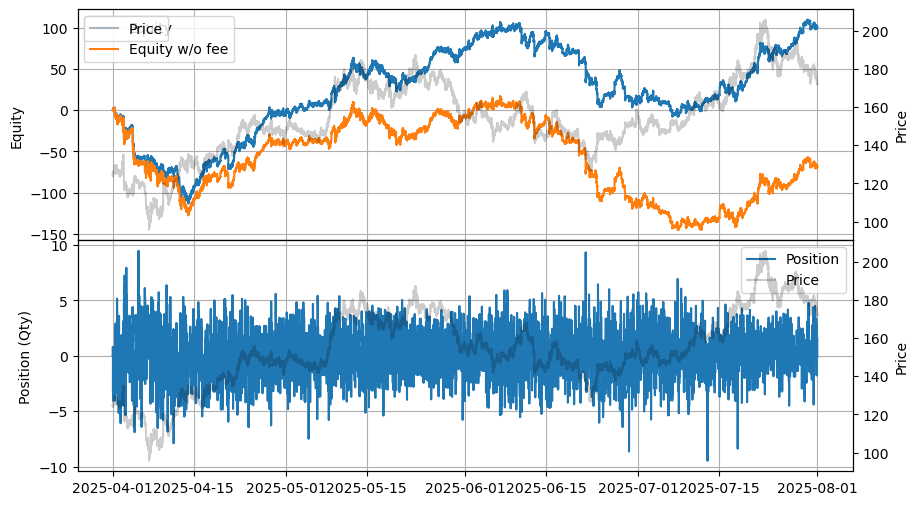

In [5]:
data = np.load('gridtrading_stats/binance_SOLUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

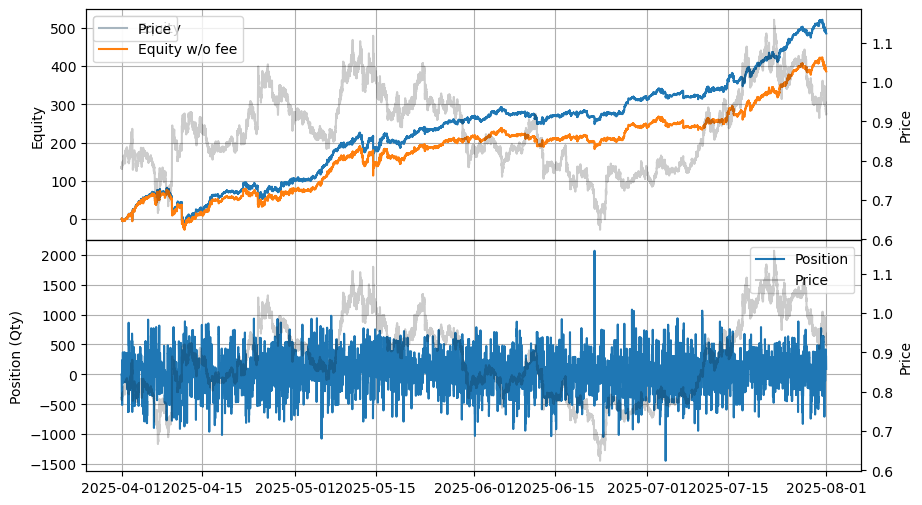

In [6]:
data = np.load('gridtrading_stats/binance_ONDOUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

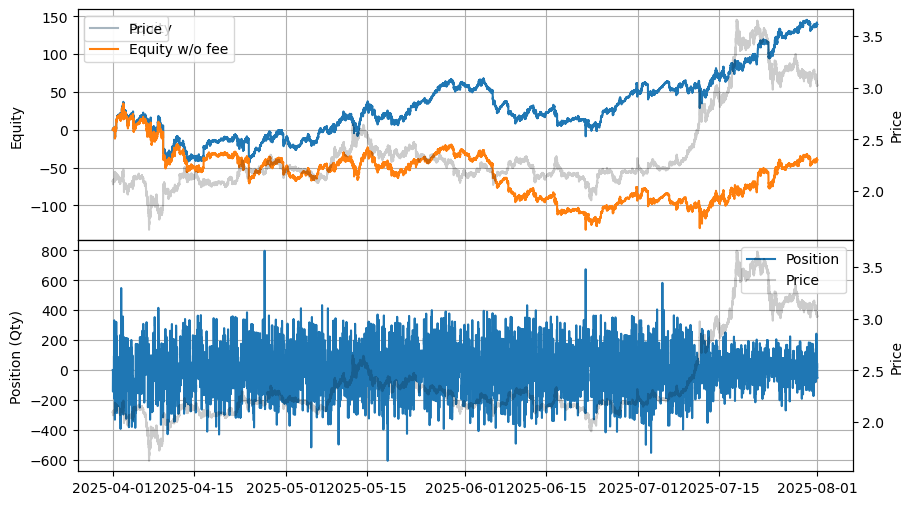

In [7]:
data = np.load('gridtrading_stats/binance_XRPUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

In [8]:
equity_values = {}
for i, (asset_name, _) in enumerate(assets.items()):
    data = np.load('gridtrading_stats/binance_{}_5.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

Text(0, 0.5, 'Cumulative Returns (%)')

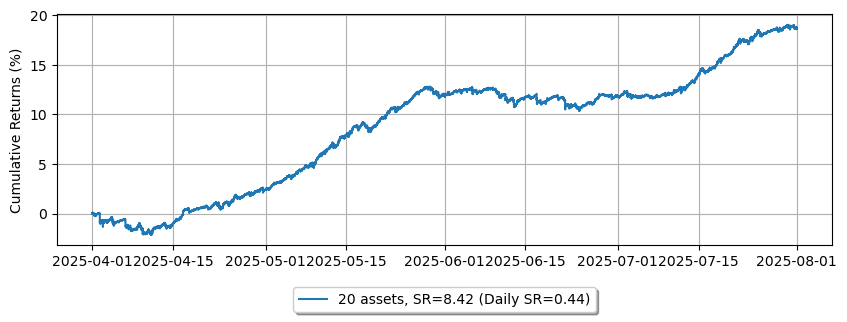

In [9]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

# 2_000 is capital for each trading asset.
net_equity_df = pl.DataFrame({
    'cum_ret': (net_equity / asset_number) / 2_000 * 100,
    'timestamp': equity['timestamp']
})
net_equity_rs_df = net_equity_df.group_by_dynamic(
    index_column='timestamp',
    every='1d'
).agg([
    pl.col('cum_ret').last()
])
pnl = net_equity_rs_df['cum_ret'].diff()
sr = pnl.mean() / pnl.std()
ann_sr = sr * np.sqrt(365)

plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')

## Bybit 

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.0025% rebate, the market maker rebate available on Bybit Futures. See <a href="https://www.bybit.com/en/help-center/article/Introduction-to-the-Market-Maker-Incentive-Program">Introduction to the Market Maker Incentive Program</a> for more details.
    
</div>

In [10]:
dates = []
date = datetime.datetime(2025, 4, 1)
until = datetime.datetime(2025, 7, 31)
while date <= until:
    dates.append(date.strftime("%Y%m%d"))
    date += datetime.timedelta(days=1)

In [11]:
latency_data = np.concatenate(
    [np.load('bybit_latency/order_latency_{}.npz'.format(date))['data'] for date in dates]
)
    
def backtest(args):
    asset_name, asset_info, vol_to_half_spread = args

    # Obtains the mid-price of the assset to determine the range of interest for the market depth.
    snapshot = np.load('bybit_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))['data']
    best_bid = max(snapshot[snapshot['ev'] & BUY_EVENT == BUY_EVENT]['px'])
    best_ask = min(snapshot[snapshot['ev'] & SELL_EVENT == SELL_EVENT]['px'])
    mid_price = (best_bid + best_ask) / 2.0

    data = ['bybit_data/{}/{}_{}.npz'.format(asset_name, asset_name, date) for date in dates]
    
    asset = (
        BacktestAsset()
            .data(data)
            # Tardis collects Bybit data from Tokyo, but the Bybit server is located in Singapore.
            # 
            # Therefore, if we assume our strategy will run in Singapore, we need to adjust for the feed latency.
            # The round-trip time (RTT) between Tokyo and Singapore is approximately 70 ms.
            # For our purposes, we subtract 30 ms as the estimated one-way latency from Singapore to Tokyo, including a small buffer.
            #
            # https://docs.tardis.dev/historical-data-details/bybit#market-data-collection-details
            # https://bybit-exchange.github.io/docs/faq#where-are-bybits-servers-located
            # https://elitwilliams.medium.com/geographic-latency-in-crypto-how-to-optimally-co-locate-your-aws-trading-server-to-any-exchange-58965ea173a8
            .latency_offset(-30_000_000)
            .initial_snapshot('bybit_data/{}/{}_20250331_eod.npz'.format(asset_name, asset_name))
            .linear_asset(1.0) 
            .intp_order_latency(latency_data)
            .power_prob_queue_model3(3.0) 
            .no_partial_fill_exchange()
            .trading_value_fee_model(-0.000025, 0.00055)
            .tick_size(asset_info['tick_size'])
            .lot_size(asset_info['lot_size'])
            .roi_lb(0)
            .roi_ub(mid_price * 10)
    )
    hbt = ROIVectorMarketDepthBacktest([asset])

    max_notional_position = 1000
    grid_num = 20
    skew = 1
    min_grid_step = asset_info['tick_size']
    
    recorder = Recorder(1, 300_000_000)

    gridtrading(hbt, recorder.recorder, vol_to_half_spread, min_grid_step, grid_num, skew, max_notional_position)

    hbt.close()

    recorder.to_npz('gridtrading_stats/bybit_{}_{}.npz'.format(asset_name, vol_to_half_spread))

In [12]:
%%capture

with open('bybit_assets.json', 'r') as f:
    assets =  json.load(f)

args = list(itertools.product(list(assets.items()), [5]))
args = [(*tup, x) for tup, x in args]
    
with Pool(4) as p:
    print(p.map(backtest, args))

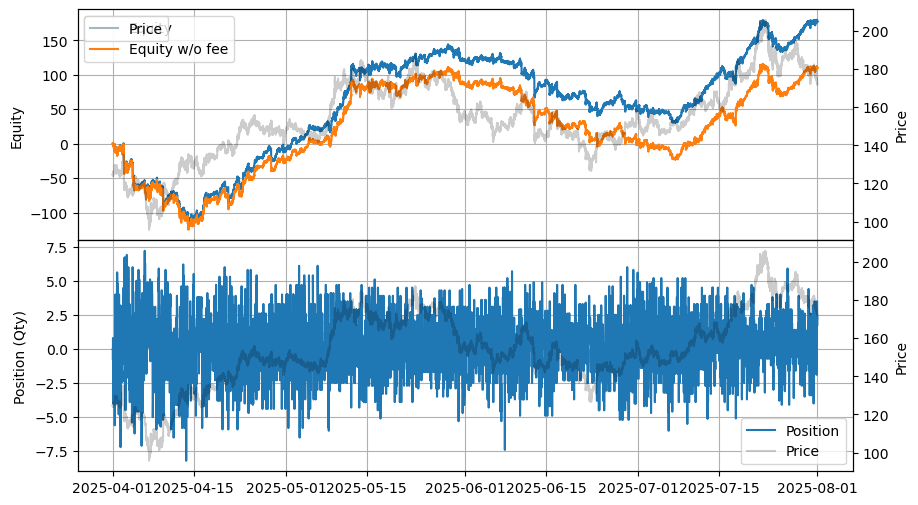

In [13]:
data = np.load('gridtrading_stats/bybit_SOLUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

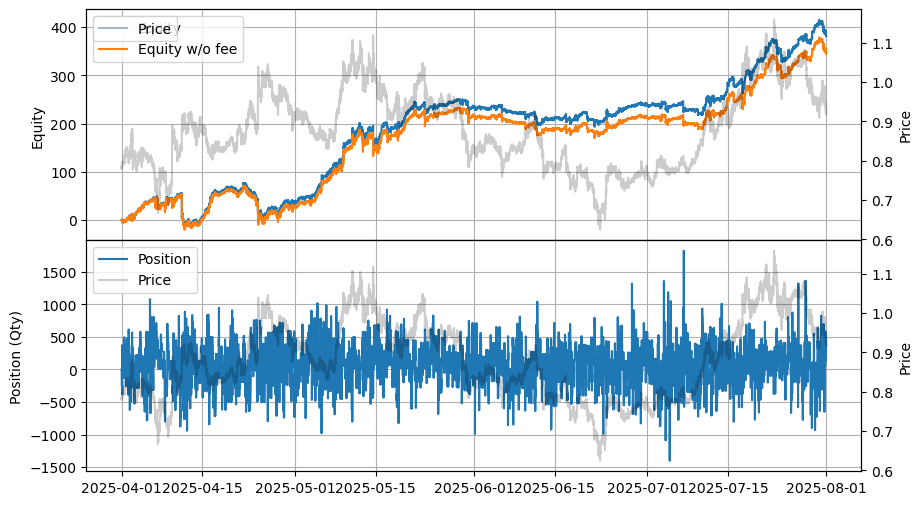

In [14]:
data = np.load('gridtrading_stats/bybit_ONDOUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

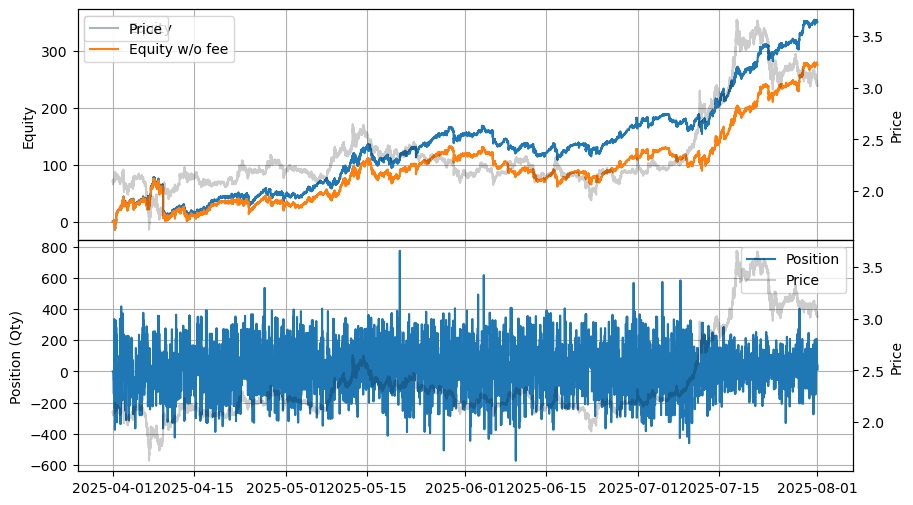

In [15]:
data = np.load('gridtrading_stats/bybit_XRPUSDT_5.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.plot()

In [16]:
equity_values = {}
for i, (asset_name, _) in enumerate(assets.items()):
    data = np.load('gridtrading_stats/bybit_{}_5.npz'.format(asset_name))['0']
    stats = (
        LinearAssetRecord(data)
            .resample('5m')
            .stats()
    )

    equity = stats.entire.with_columns(
        (pl.col('equity_wo_fee') - pl.col('fee')).alias('equity')
    ).select(['timestamp', 'equity'])
    equity_values[asset_name] = equity

Text(0, 0.5, 'Cumulative Returns (%)')

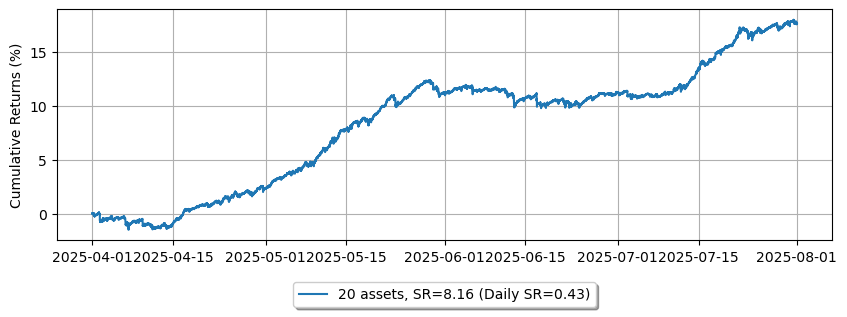

In [17]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity['equity'].clone()
    else:
        net_equity += equity['equity'].clone()

# 2_000 is capital for each trading asset.
net_equity_df = pl.DataFrame({
    'cum_ret': (net_equity / asset_number) / 2_000 * 100,
    'timestamp': equity['timestamp']
})
net_equity_rs_df = net_equity_df.group_by_dynamic(
    index_column='timestamp',
    every='1d'
).agg([
    pl.col('cum_ret').last()
])
pnl = net_equity_rs_df['cum_ret'].diff()
sr = pnl.mean() / pnl.std()
ann_sr = sr * np.sqrt(365)

plt.plot(net_equity_df['timestamp'], net_equity_df['cum_ret'])
legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))

plt.legend(
    legend,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=3
)

plt.grid()
plt.ylabel('Cumulative Returns (%)')